In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 12})

from matplotlib import font_manager
font_manager.fontManager.addfont('../../misc/lucida-sans-unicode.ttf')

import seaborn as sns
tregs.mpl_pboc.plotting_style()

{'green': '#7AA974',
 'light_green': '#BFD598',
 'pale_green': '#DCECCB',
 'yellow': '#EAC264',
 'light_yellow': '#F3DAA9',
 'pale_yellow': '#FFEDCE',
 'blue': '#738FC1',
 'light_blue': '#A9BFE3',
 'pale_blue': '#C9D7EE',
 'red': '#D56C55',
 'light_red': '#E8B19D',
 'pale_red': '#F1D4C9',
 'purple': '#AB85AC',
 'light_purple': '#D4C2D9',
 'dark_green': '#7E9D90',
 'dark_brown': '#905426'}

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [5]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

In [6]:
n_NS = len(genome)
n_p = 4600
n_r = 15
ep_wt = -3
er_wt = -15

### Varying bin sizes

In [7]:
df = tregs.simulate.simrep(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']

exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                        smoothed=True, windowsize=3)

In [8]:
def plot_footprint(promoter, mut_list, mu_data, nbins, upper_bound, exshift_list):
    footprint = tregs.footprint.get_info_footprint(mut_list, mu_data,
                                                    promoter, nbins, upper_bound,
                                                    smoothed=True, windowsize=3)
    
    fig, ax = plt.subplots(figsize=(12,2.5))

    ax.axvspan(-38, -30, alpha=0.7, color='#A9BFE3')
    ax.axvspan(-15, -5, alpha=0.7, color='#A9BFE3')
    ax.axvspan(2, 20, alpha=0.7, color='#E8B19D')

    ax.set_ylim(top=max(footprint)*1.15)
    ax.add_patch(mpl.patches.Rectangle((-38, max(footprint)*1.15),
                                            8,
                                            max(footprint) * 0.2,
                                            facecolor='#738FC1',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(-38 + 0.5 * 8, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
            ha='center', va='baseline')

    ax.add_patch(mpl.patches.Rectangle((-15, max(footprint)*1.15),
                                            10,
                                            max(footprint) * 0.2,
                                            facecolor='#738FC1',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(-15 + 0.5 * 10, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
            ha='center', va='baseline')

    ax.add_patch(mpl.patches.Rectangle((2, max(footprint)*1.15),
                                            18,
                                            max(footprint) * 0.2,
                                            facecolor='#D56C55',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(2 + 0.5 * 18, max(footprint) * 1.2, 'LacI', fontsize = 10, color = 'k',
            ha='center', va='baseline')


    windowsize=3
    cut = int((windowsize - 1) / 2)
    x = np.arange(-115 + cut, 45 - cut)
    shiftcolors = [('#D56C55' if exshift > 0 else '#738FC1') for exshift in exshift_list]
    ax.bar(x, footprint, color=shiftcolors, edgecolor=None, linewidth=0)
    ax.set_ylabel('Information (bits)', fontsize=12)

    custom_lines = [Line2D([0], [0], color='#D56C55', lw=4),
                    Line2D([0], [0], color='#738FC1', lw=4)]
    plt.legend(custom_lines,
            ['Mutation\nincreases\nexpression', 'Mutation\ndecreases\nexpression'],
            bbox_to_anchor=(1.2, 0.95), frameon=False)

    plt.tight_layout()
    plt.show()

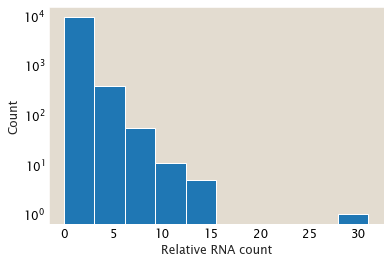

In [9]:
fig, ax = plt.subplots()
ax.hist(mu_data)
ax.set_yscale('log')
ax.set_xlabel('Relative RNA count')
ax.set_ylabel('Count')
plt.show()

Bin boundary: 1
size of bin 1: 6787; size of bin 2: 3213


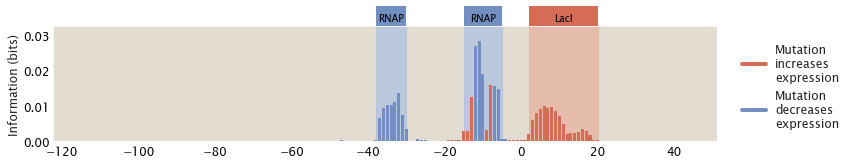

In [10]:
nbins = 2
upper_bound = 1
mu_bins, bin_cnt = tregs.footprint.bin_expression_levels(mu_data, nbins, upper_bound)
print('Bin boundary: {}'.format(upper_bound))
print('size of bin 1: {}; size of bin 2: {}'.format(bin_cnt[0], bin_cnt[1]))
plot_footprint(promoter, mut_list, mu_data, nbins, upper_bound, exshift_list)

Bin boundary: 0.8773070912124412
size of bin 1: 6464; size of bin 2: 3536


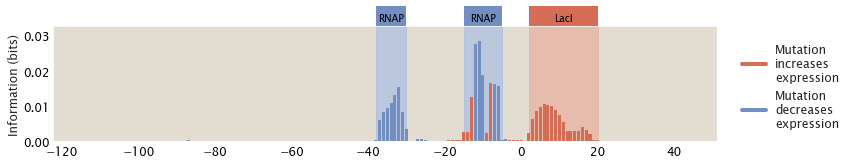

In [11]:
nbins = 2
upper_bound = np.mean(mu_data)
mu_bins, bin_cnt = tregs.footprint.bin_expression_levels(mu_data, nbins, upper_bound)
print('Bin boundary: {}'.format(upper_bound))
print('size of bin 1: {}; size of bin 2: {}'.format(bin_cnt[0], bin_cnt[1]))
plot_footprint(promoter, mut_list, mu_data, nbins, upper_bound, exshift_list)

Bin boundary: 0.7050120623451817
size of bin 1: 5936; size of bin 2: 4064


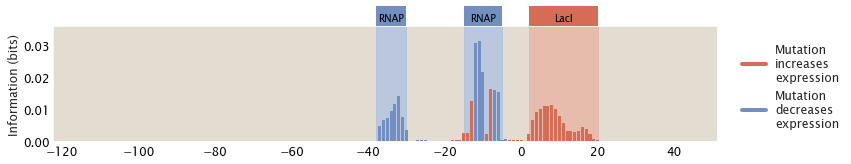

In [12]:
nbins = 2
upper_bound = np.exp(np.mean(np.log(mu_data[mu_data > 0])))
mu_bins, bin_cnt = tregs.footprint.bin_expression_levels(mu_data, nbins, upper_bound)
print('Bin boundary: {}'.format(upper_bound))
print('size of bin 1: {}; size of bin 2: {}'.format(bin_cnt[0], bin_cnt[1]))
plot_footprint(promoter, mut_list, mu_data, nbins, upper_bound, exshift_list)

Bin boundary: 4.460707403689184
size of bin 1: 9803; size of bin 2: 197


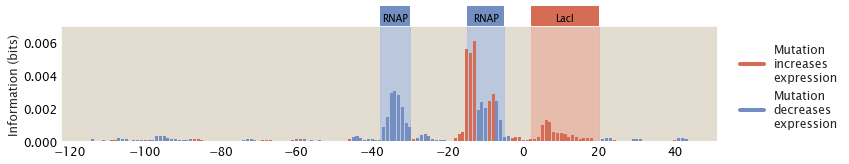

In [12]:
nbins = 2
upper_bound = np.mean(mu_data) * 5
mu_bins, bin_cnt = tregs.footprint.bin_expression_levels(mu_data, nbins, upper_bound)
print('Bin boundary: {}'.format(upper_bound))
print('size of bin 1: {}; size of bin 2: {}'.format(bin_cnt[0], bin_cnt[1]))
plot_footprint(promoter, mut_list, mu_data, nbins, upper_bound, exshift_list)

Bin boundary: 0.4386535456062206
size of bin 1: 5079; size of bin 2: 4921


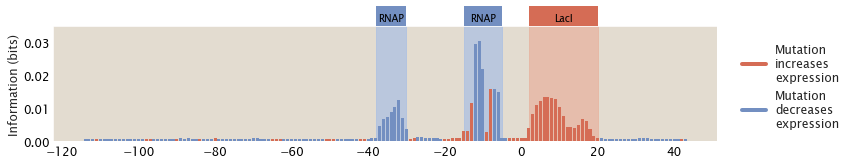

In [13]:
nbins = 2
upper_bound = np.mean(mu_data) * 0.5
mu_bins, bin_cnt = tregs.footprint.bin_expression_levels(mu_data, nbins, upper_bound)
print('Bin boundary: {}'.format(upper_bound))
print('size of bin 1: {}; size of bin 2: {}'.format(bin_cnt[0], bin_cnt[1]))
plot_footprint(promoter, mut_list, mu_data, nbins, upper_bound, exshift_list)

Bin boundary: 0.3509228364849765
size of bin 1: 5520; size of bin 2: 4480


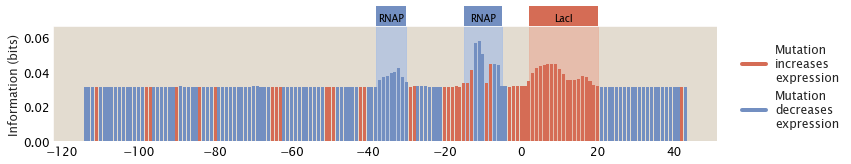

In [14]:
nbins = 2
upper_bound = np.mean(mu_data) * 0.4
mu_bins, bin_cnt = tregs.footprint.bin_expression_levels(mu_data, nbins, upper_bound)
print('Bin boundary: {}'.format(upper_bound))
print('size of bin 1: {}; size of bin 2: {}'.format(bin_cnt[0], bin_cnt[1]))
plot_footprint(promoter, mut_list, mu_data, nbins, upper_bound, exshift_list)

In [23]:
def MI(list_p_b, p_mu, list_joint_p,
       len_promoter=160):
    mutual_info = []
    for position in range(len_promoter):
        p_b = list_p_b[position]
        joint_p = list_joint_p[position]

        mi = 0
        print(joint_p)
        for i in range(len(p_mu)):
            print('{:2f}, {:2f}'.format(joint_p[0][i], p_b[0] * p_mu[i]))
            mi += joint_p[0][i] * np.log2(joint_p[0][i] / (p_b[0] * p_mu[i]))
            print('{:2f}, {:2f}'.format(joint_p[1][i], p_b[1] * p_mu[i]))
            mi += joint_p[1][i] * np.log2(joint_p[1][i] / (p_b[1] * p_mu[i]))
        print('{:2f}'.format(mi))
        print('\n')
        mutual_info.append(mi)
    return mutual_info

In [24]:
nbins = 2
upper_bound = np.mean(mu_data)
n_seqs = len(mut_list)
all_mutarr = tregs.footprint.match_seqs(promoter, mut_list)
list_p_b = tregs.footprint.get_p_b(all_mutarr, n_seqs)
mu_bins, bin_cnt = tregs.footprint.bin_expression_levels(mu_data, nbins, upper_bound)
p_mu = tregs.footprint.get_p_mu(bin_cnt, n_seqs)
list_joint_p = tregs.footprint.get_joint_p(all_mutarr, mu_bins, nbins,
                                           pseudocount=10**(-6), len_promoter=160)
#print('finished calculating joint probability distribution: {}'.format(datetime.datetime.now()))
footprint = MI(list_p_b, p_mu, list_joint_p)

[[0.5778 0.3231]
 [0.0659 0.0332]]
0.577800, 0.579909
0.065900, 0.063791
0.323100, 0.320991
0.033200, 0.035309
0.000158


[[0.5784 0.3225]
 [0.0653 0.0338]]
0.578400, 0.579909
0.065300, 0.063791
0.322500, 0.320991
0.033800, 0.035309
0.000081


[[0.581  0.3217]
 [0.0627 0.0346]]
0.581000, 0.581068
0.062700, 0.062632
0.321700, 0.321632
0.034600, 0.034668
0.000000


[[0.5769 0.3239]
 [0.0668 0.0324]]
0.576900, 0.579845
0.066800, 0.063855
0.323900, 0.320955
0.032400, 0.035345
0.000309


[[0.5799 0.3216]
 [0.0638 0.0347]]
0.579900, 0.580296
0.063800, 0.063404
0.321600, 0.321204
0.034700, 0.035096
0.000006


[[0.5782 0.317 ]
 [0.0655 0.0393]]
0.578200, 0.576240
0.065500, 0.067460
0.317000, 0.318960
0.039300, 0.037340
0.000128


[[0.5794 0.3164]
 [0.0643 0.0399]]
0.579400, 0.576626
0.064300, 0.067074
0.316400, 0.319174
0.039900, 0.037126
0.000257


[[0.578  0.3198]
 [0.0657 0.0365]]
0.578000, 0.577914
0.065700, 0.065786
0.319800, 0.319886
0.036500, 0.036414
0.000000


[[0.5796 0.3225]
 [0.064

In [25]:
nbins = 2
upper_bound = np.mean(mu_data) * 0.5
n_seqs = len(mut_list)
all_mutarr = tregs.footprint.match_seqs(promoter, mut_list)
list_p_b = tregs.footprint.get_p_b(all_mutarr, n_seqs)
mu_bins, bin_cnt = tregs.footprint.bin_expression_levels(mu_data, nbins, upper_bound)
p_mu = tregs.footprint.get_p_mu(bin_cnt, n_seqs)
list_joint_p = tregs.footprint.get_joint_p(all_mutarr, mu_bins, nbins,
                                           pseudocount=10**(-6), len_promoter=160)
#print('finished calculating joint probability distribution: {}'.format(datetime.datetime.now()))
footprint = MI(list_p_b, p_mu, list_joint_p)

[[0.4406 0.4603]
 [0.0493 0.0498]]
0.440600, 0.459549
0.049300, 0.050551
0.460300, 0.441351
0.049800, 0.048549
0.001196


[[0.4396 0.4613]
 [0.0503 0.0488]]
0.439600, 0.459549
0.050300, 0.050551
0.461300, 0.441351
0.048800, 0.048549
0.001277


[[0.4407 0.462 ]
 [0.0492 0.0481]]
0.440700, 0.460467
0.049200, 0.049633
0.462000, 0.442233
0.048100, 0.047667
0.001255


[[0.4397 0.4611]
 [0.0502 0.049 ]]
0.439700, 0.459498
0.050200, 0.050602
0.461100, 0.441302
0.049000, 0.048598
0.001260


[[0.4424 0.4591]
 [0.0475 0.051 ]]
0.442400, 0.459855
0.047500, 0.050245
0.459100, 0.441645
0.051000, 0.048255
0.001196


[[0.4416 0.4536]
 [0.0483 0.0565]]
0.441600, 0.456642
0.048300, 0.053458
0.453600, 0.438558
0.056500, 0.051342
0.001462


[[0.4398 0.456 ]
 [0.0501 0.0541]]
0.439800, 0.456948
0.050100, 0.053152
0.456000, 0.438852
0.054100, 0.051048
0.001205


[[0.4401 0.4577]
 [0.0498 0.0524]]
0.440100, 0.457968
0.049800, 0.052132
0.457700, 0.439832
0.052400, 0.050068
0.001180


[[0.4403 0.4618]
 [0.049